# __THƯ VIỆN__

In [1]:
import pandas as pd
import numpy as np
import torch
import ast

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.model_selection import train_test_split

import string
import advertools as adv
import emoji
import regex as re
from underthesea import word_tokenize, pos_tag

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import import_ipynb
import MLTunning as MLT

# __PREPROCESS__

In [7]:
def preprocess_text(dataset, col_name, teencode_dict_path):
    # 1. Convert text to lowercase
    dataset[col_name] = dataset[col_name].str.lower()

    # 2. Load teencode dictionary
    teencode_dict = dict(pd.read_csv(teencode_dict_path, delimiter='\t').values)

    # 3. Handle teencode
    def handle_teencode(text, teencode_dict):
        return ' '.join([teencode_dict[word] if word in teencode_dict else word for word in text.split(' ')])

    dataset[col_name] = dataset[col_name].apply(lambda x: handle_teencode(str(x), teencode_dict))

    # 4. Standardize stretched words (e.g., "heeeellooo" -> "helo")
    dataset[col_name] = dataset[col_name].apply(lambda x: re.sub(r'(\D)\1+', r'\1', str(x)))

    # 5. Remove words with length greater than 7
    def remove_words_over_length(text, length):
        return ' '.join([word for word in text.split(' ') if len(word) <= length])

    dataset[col_name] = dataset[col_name].apply(lambda x: remove_words_over_length(str(x), 7))

    # 6. Remove white spaces, \n, \t, \r, \v
    dataset[col_name] = dataset[col_name].apply(lambda x: re.sub(r'\s+', ' ', str(x).strip()))

    # 7. Remove numbers and special characters
    def remove_numbers_and_special_characters(text):
        text = re.sub(r'[' + string.punctuation + ']', '', text)  # Remove special characters
        text = re.sub(r'\d+', '', text)  # Remove numbers
        return text

    dataset[col_name] = dataset[col_name].apply(lambda x: remove_numbers_and_special_characters(str(x)))

    #8. Drop NA data
    dataset.dropna(subset=[col_name], inplace=True)

    # 9. Tokenize text using word_tokenize from underthesea
    dataset['word_tokenize'] = dataset[col_name].apply(lambda x: word_tokenize(str(x), format='text'))

    return dataset

In [3]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")
model = AutoModel.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")

def vectorize_comment(comment):
    inputs = tokenizer(comment, return_tensors="pt", padding=True, truncation=True)
    # Lấy hidden states
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state
    sentence_embedding = hidden_states.mean(dim=1)
    return sentence_embedding.squeeze(0).numpy()

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at wonrax/phobert-base-vietnamese-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def convert_embeddings_to_tensor(df):
    embeddings = df['embedding'].apply(lambda x: tf.convert_to_tensor(np.array(x).reshape(1, -1), dtype=tf.float32))

    embeddings_tensor = np.array(embeddings.tolist())

    return embeddings_tensor

# __PREDICT__

In [9]:
file_path = r'testset.xlsx'
df = pd.read_excel(file_path)
df.head(5)

,Unnamed: 0,orderid,itemid,itemname,cmtid,ctime,rating,userid,shopid,comment,...,image_data,key_media,is_super_review,region,original_item_info,show_super_review_tag,super_review_status,template_tags,ItemRatingReply,display_variation_filter
0,0,92941960095687,11305172432,Áo sơ mi,6980041307,1640013969,1,393720644,259681663,Áo sơ mi trắng này chất lụa mặc vào mát lạnh l...,...,[{'image_id': 'acdfe3c4e513bf379e1be34828eb69a...,"{'key_media_code': 1, 'key_media_id': 'vn_091a...",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,NaN,NaN,NaN
1,1,88914825374056,11305172432,Áo sơ mi,6443720741,1635589554,1,41678132,259681663,Chất lượng sản phẩm trên cả hy vọng. \nÁo đườn...,...,[{'image_id': '194cf53082a08ce28090c3e0c75f438...,"{'key_media_code': 1, 'key_media_id': 'vn_7c48...",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,NaN,NaN,NaN
2,2,101639107204879,11305172432,Áo sơ mi,7911794551,1648665082,1,59135900,259681663,Đây là một trong những shop menswear cute nhất...,...,[{'image_id': '0d503deada278926fd8e443356d588a...,"{'key_media_code': 0, 'key_media_id': ''}",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,NaN,NaN,NaN
3,3,151066957232306,11305172432,Áo sơ mi,12944626201,1697820759,1,958994801,259681663,Đúng với mô tả:đúng\nChất liệu:vải\nMàu sắc:tr...,...,[{'image_id': 'vn-11134103-7r98o-ln36f5i7e2432...,"{'key_media_code': 0, 'key_media_id': ''}",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,"['Đúng với mô tả', 'Chất liệu', 'Màu sắc']",NaN,NaN
4,4,89477296313770,11305172432,Áo sơ mi,6504669981,1636185616,1,5474768,259681663,Camera mình hơi xấu nhưng mà lần đầu tiên mua ...,...,[{'image_id': '7305922d12a767bd702a0ec1ace0dff...,"{'key_media_code': 0, 'key_media_id': ''}",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,NaN,NaN,NaN


In [10]:
df = preprocess_text(df, 'comment', 'teencode.txt')

In [11]:
df['embedding'] = df['word_tokenize'].apply(vectorize_comment)

In [13]:
X = df['embedding']
y = df['rating']

In [16]:
X = convert_embeddings_to_tensor(df)

2024-12-16 21:08:38,762 | WARNING | saving_utils.py:256 | try_build_compiled_arguments | Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


Model loaded successfully!
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
Accuracy on test set: 0.93

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.87      0.93        71
    Positive       0.87      0.98      0.93        63

    accuracy                           0.93       134
   macro avg       0.93      0.93      0.93       134
weighted avg       0.93      0.93      0.93       134



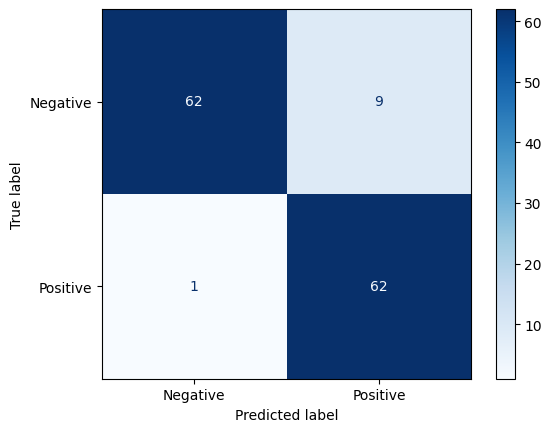

In [19]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Tải lại mô hình từ file .h5
model_path = "C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\NopThay\\model\\PhoBERT_LSTM_chung.h5"
model = load_model(model_path)
print("Model loaded successfully!")

# Nếu chỉ muốn dự đoán trên dữ liệu mới:
y_pred = model.predict(X)
y_pred = (y_pred > 0.5).astype(int)  # Chuyển đổi dự đoán sang nhãn nhị phân (0 hoặc 1)

# So sánh với nhãn thực tế
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=["Negative", "Positive"]))

# Vẽ ma trận nhầm lẫn
ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels=["Negative", "Positive"], cmap="Blues")
plt.show()